In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

from sklearn.model_selection import train_test_split

## Import dataset

In [36]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


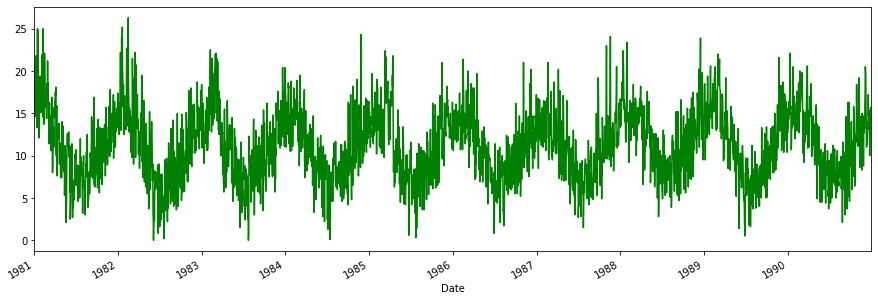

In [37]:
df.Temp.plot(figsize=(15,5), color='g');

## Dataset Splitting

In [38]:
## Pada data time series data tidak boleh dishuffle(diacak) 
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

## Dataset dan Dataloader

In [39]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [40]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, 'Temp', seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, 'Temp', seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



- N = Jumlah data
- S = Squence
- F = Feature

## Arsitektur dan config

In [41]:
class BiLSTM(nn.Module):
    def __init__(self, input_size,output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [42]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size":1,
    "hidden_size":64,
    "num_layers":2,
    "dropout":0
})

## Training Preparation

In [50]:
model = BiLSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.0008)
callback = Callback(model, config, outdir="model/bilstm")

## Training

In [51]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 130.9328 | Test_cost  = 125.8909 | 




Epoch     2
Train_cost  = 108.3993 | Test_cost  = 99.1271 | 




Epoch     3
Train_cost  = 82.3061 | Test_cost  = 73.0674 | 




Epoch     4
Train_cost  = 59.2507 | Test_cost  = 52.4866 | 




Epoch     5
Train_cost  = 42.1843 | Test_cost  = 38.0256 | 




Epoch     6
Train_cost  = 30.7871 | Test_cost  = 28.7513 | 




Epoch     7
Train_cost  = 23.9552 | Test_cost  = 23.3839 | 




Epoch     8
Train_cost  = 20.2067 | Test_cost  = 20.3320 | 




Epoch     9
Train_cost  = 18.2196 | Test_cost  = 18.6648 | 




Epoch    10
Train_cost  = 17.2671 | Test_cost  = 17.8328 | 




Epoch    11
Train_cost  = 16.8738 | Test_cost  = 17.4441 | 




Epoch    12
Train_cost  = 16.7334 | Test_cost  = 17.2662 | 




Epoch    13
Train_cost  = 16.6845 | Test_cost  = 17.1877 | 




Epoch    14
Train_cost  = 16.6668 | Test_cost  = 17.1554 | 




Epoch    15
Train_cost  = 16.6501 | Test_cost  = 17.1428 | 




Epoch    16
Train_cost  = 16.6340 | Test_cost  = 17.1401 | 




Epoch    17
Train_cost  = 16.6168 | Test_cost  = 17.1389 | 




Epoch    18
Train_cost  = 16.5991 | Test_cost  = 17.1370 | 




Epoch    19
Train_cost  = 16.5778 | Test_cost  = 17.1222 | 




Epoch    20
Train_cost  = 16.5434 | Test_cost  = 17.0956 | 


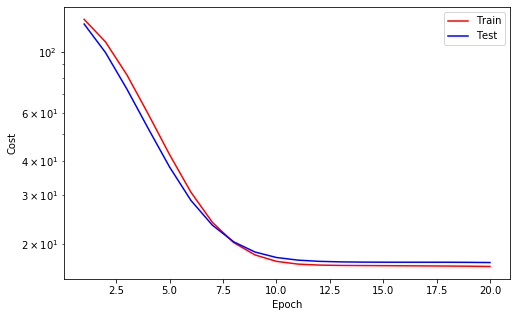



Epoch    21
Train_cost  = 16.5076 | Test_cost  = 17.0588 | 




Epoch    22
Train_cost  = 16.4568 | Test_cost  = 16.9941 | 




Epoch    23
Train_cost  = 16.3638 | Test_cost  = 16.8535 | 




Epoch    24
Train_cost  = 16.1814 | Test_cost  = 16.5709 | 




Epoch    25
Train_cost  = 15.9011 | Test_cost  = 16.2187 | 




Epoch    26
Train_cost  = 15.5649 | Test_cost  = 15.8306 | 




Epoch    27
Train_cost  = 15.1640 | Test_cost  = 15.3735 | 




Epoch    28
Train_cost  = 14.6971 | Test_cost  = 14.8165 | 




Epoch    29
Train_cost  = 14.0717 | Test_cost  = 14.0893 | 




Epoch    30
Train_cost  = 13.2091 | Test_cost  = 12.9699 | 




Epoch    31
Train_cost  = 11.8955 | Test_cost  = 11.3988 | 




Epoch    32
Train_cost  = 10.3676 | Test_cost  = 9.8283 | 




Epoch    33
Train_cost  = 9.1299 | Test_cost  = 8.6610 | 




Epoch    34
Train_cost  = 8.1939 | Test_cost  = 7.7771 | 




Epoch    35
Train_cost  = 7.4887 | Test_cost  = 6.9672 | 




Epoch    36
Train_cost  = 6.8921 | Test_cost  = 6.3857 | 




Epoch    37
Train_cost  = 6.4162 | Test_cost  = 5.8734 | 




Epoch    38
Train_cost  = 5.9946 | Test_cost  = 5.5004 | 




Epoch    39
Train_cost  = 5.6356 | Test_cost  = 5.1560 | 




Epoch    40
Train_cost  = 5.2993 | Test_cost  = 4.8498 | 


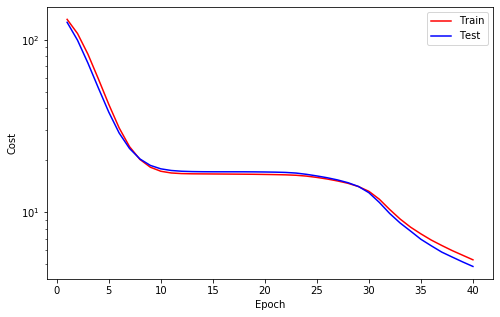



Epoch    41
Train_cost  = 5.0218 | Test_cost  = 4.5625 | 




Epoch    42
Train_cost  = 4.7479 | Test_cost  = 4.2862 | 




Epoch    43
Train_cost  = 4.5050 | Test_cost  = 4.0166 | 




Epoch    44
Train_cost  = 4.2659 | Test_cost  = 3.7866 | 




Epoch    45
Train_cost  = 4.0554 | Test_cost  = 3.5708 | 




Epoch    46
Train_cost  = 3.8573 | Test_cost  = 3.3777 | 




Epoch    47
Train_cost  = 3.6761 | Test_cost  = 3.1909 | 




Epoch    48
Train_cost  = 3.4974 | Test_cost  = 3.0096 | 




Epoch    49
Train_cost  = 3.3268 | Test_cost  = 2.8441 | 




Epoch    50
Train_cost  = 3.1709 | Test_cost  = 2.6829 | 




Epoch    51
Train_cost  = 3.0210 | Test_cost  = 2.5271 | 




Epoch    52
Train_cost  = 2.8754 | Test_cost  = 2.3827 | 




Epoch    53
Train_cost  = 2.7352 | Test_cost  = 2.2416 | 




Epoch    54
Train_cost  = 2.5973 | Test_cost  = 2.1037 | 




Epoch    55
Train_cost  = 2.4628 | Test_cost  = 1.9702 | 




Epoch    56
Train_cost  = 2.3315 | Test_cost  = 1.8421 | 




Epoch    57
Train_cost  = 2.2041 | Test_cost  = 1.7191 | 




Epoch    58
Train_cost  = 2.0807 | Test_cost  = 1.6023 | 




Epoch    59
Train_cost  = 1.9614 | Test_cost  = 1.4916 | 




Epoch    60
Train_cost  = 1.8458 | Test_cost  = 1.3867 | 


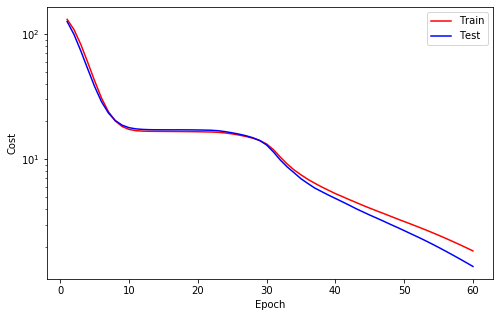



Epoch    61
Train_cost  = 1.7347 | Test_cost  = 1.2883 | 




Epoch    62
Train_cost  = 1.6293 | Test_cost  = 1.1954 | 




Epoch    63
Train_cost  = 1.5298 | Test_cost  = 1.1081 | 




Epoch    64
Train_cost  = 1.4383 | Test_cost  = 1.0295 | 




Epoch    65
Train_cost  = 1.3562 | Test_cost  = 0.9597 | 




Epoch    66
Train_cost  = 1.2846 | Test_cost  = 0.8981 | 




Epoch    67
Train_cost  = 1.2242 | Test_cost  = 0.8467 | 




Epoch    68
Train_cost  = 1.1725 | Test_cost  = 0.8025 | 




Epoch    69
Train_cost  = 1.1287 | Test_cost  = 0.7639 | 




Epoch    70
Train_cost  = 1.0903 | Test_cost  = 0.7293 | 




Epoch    71
Train_cost  = 1.0561 | Test_cost  = 0.6980 | 




Epoch    72
Train_cost  = 1.0251 | Test_cost  = 0.6693 | 




Epoch    73
Train_cost  = 0.9965 | Test_cost  = 0.6432 | 




Epoch    74
Train_cost  = 0.9700 | Test_cost  = 0.6194 | 




Epoch    75
Train_cost  = 0.9452 | Test_cost  = 0.5976 | 




Epoch    76
Train_cost  = 0.9221 | Test_cost  = 0.5777 | 




Epoch    77
Train_cost  = 0.9005 | Test_cost  = 0.5593 | 




Epoch    78
Train_cost  = 0.8802 | Test_cost  = 0.5423 | 




Epoch    79
Train_cost  = 0.8613 | Test_cost  = 0.5265 | 




Epoch    80
Train_cost  = 0.8435 | Test_cost  = 0.5118 | 


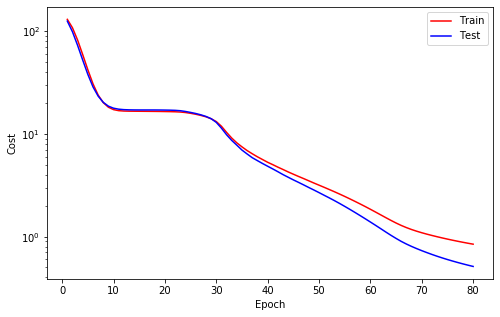



Epoch    81
Train_cost  = 0.8268 | Test_cost  = 0.4981 | 




Epoch    82
Train_cost  = 0.8110 | Test_cost  = 0.4854 | 




Epoch    83
Train_cost  = 0.7961 | Test_cost  = 0.4736 | 




Epoch    84
Train_cost  = 0.7821 | Test_cost  = 0.4625 | 




Epoch    85
Train_cost  = 0.7687 | Test_cost  = 0.4522 | 




Epoch    86
Train_cost  = 0.7560 | Test_cost  = 0.4426 | 




Epoch    87
Train_cost  = 0.7439 | Test_cost  = 0.4336 | 




Epoch    88
Train_cost  = 0.7324 | Test_cost  = 0.4252 | 




Epoch    89
Train_cost  = 0.7214 | Test_cost  = 0.4174 | 




Epoch    90
Train_cost  = 0.7109 | Test_cost  = 0.4100 | 




Epoch    91
Train_cost  = 0.7009 | Test_cost  = 0.4032 | 




Epoch    92
Train_cost  = 0.6913 | Test_cost  = 0.3968 | 




Epoch    93
Train_cost  = 0.6822 | Test_cost  = 0.3908 | 




Epoch    94
Train_cost  = 0.6734 | Test_cost  = 0.3853 | 




Epoch    95
Train_cost  = 0.6650 | Test_cost  = 0.3801 | 




Epoch    96
Train_cost  = 0.6570 | Test_cost  = 0.3753 | 




Epoch    97
Train_cost  = 0.6492 | Test_cost  = 0.3708 | 




Epoch    98
Train_cost  = 0.6418 | Test_cost  = 0.3666 | 




Epoch    99
Train_cost  = 0.6346 | Test_cost  = 0.3627 | 




Epoch   100
Train_cost  = 0.6276 | Test_cost  = 0.3591 | 


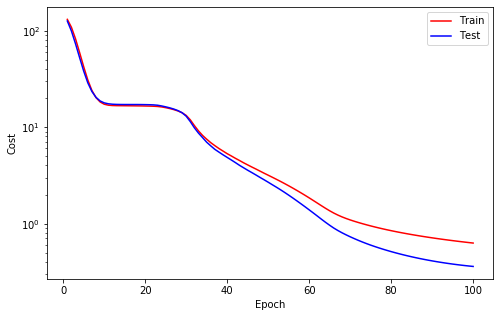



Epoch   101
Train_cost  = 0.6209 | Test_cost  = 0.3557 | 




Epoch   102
Train_cost  = 0.6145 | Test_cost  = 0.3526 | 




Epoch   103
Train_cost  = 0.6082 | Test_cost  = 0.3497 | 




Epoch   104
Train_cost  = 0.6022 | Test_cost  = 0.3470 | 




Epoch   105
Train_cost  = 0.5963 | Test_cost  = 0.3445 | 




Epoch   106
Train_cost  = 0.5906 | Test_cost  = 0.3422 | 




Epoch   107
Train_cost  = 0.5850 | Test_cost  = 0.3400 | 




Epoch   108
Train_cost  = 0.5796 | Test_cost  = 0.3379 | 




Epoch   109
Train_cost  = 0.5743 | Test_cost  = 0.3360 | 




Epoch   110
Train_cost  = 0.5692 | Test_cost  = 0.3341 | 




Epoch   111
Train_cost  = 0.5642 | Test_cost  = 0.3324 | 




Epoch   112
Train_cost  = 0.5594 | Test_cost  = 0.3307 | 




Epoch   113
Train_cost  = 0.5547 | Test_cost  = 0.3291 | 




Epoch   114
Train_cost  = 0.5500 | Test_cost  = 0.3275 | 




Epoch   115
Train_cost  = 0.5456 | Test_cost  = 0.3260 | 




Epoch   116
Train_cost  = 0.5412 | Test_cost  = 0.3246 | 




Epoch   117
Train_cost  = 0.5369 | Test_cost  = 0.3233 | 




Epoch   118
Train_cost  = 0.5328 | Test_cost  = 0.3220 | 




Epoch   119
Train_cost  = 0.5288 | Test_cost  = 0.3208 | 




Epoch   120
Train_cost  = 0.5249 | Test_cost  = 0.3198 | 


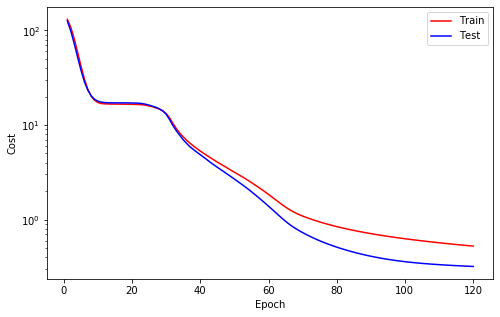



Epoch   121
Train_cost  = 0.5212 | Test_cost  = 0.3188 | 




Epoch   122
Train_cost  = 0.5177 | Test_cost  = 0.3178 | 




Epoch   123
Train_cost  = 0.5143 | Test_cost  = 0.3170 | 




Epoch   124
Train_cost  = 0.5112 | Test_cost  = 0.3162 | 




Epoch   125
Train_cost  = 0.5082 | Test_cost  = 0.3155 | 




Epoch   126
Train_cost  = 0.5056 | Test_cost  = 0.3148 | 




Epoch   127
Train_cost  = 0.5032 | Test_cost  = 0.3141 | 




Epoch   128
Train_cost  = 0.5011 | Test_cost  = 0.3133 | 




Epoch   129
Train_cost  = 0.4994 | Test_cost  = 0.3120 | 




Epoch   130
Train_cost  = 0.4981 | Test_cost  = 0.3097 | 




Epoch   131
Train_cost  = 0.4968 | Test_cost  = 0.3069 | 




Epoch   132
Train_cost  = 0.4945 | Test_cost  = 0.3050 | 




Epoch   133
Train_cost  = 0.4890 | Test_cost  = 0.3058 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3050




Epoch   134
Train_cost  = 0.4807 | Test_cost  = 0.3081 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3050




Epoch   135
Train_cost  = 0.4777 | Test_cost  = 0.3111 | 
==> EarlyStop patience =  3 | Best test_cost: 0.3050




Epoch   136
Train_cost  = 0.4841 | Test_cost  = 0.3132 | 
==> EarlyStop patience =  4 | Best test_cost: 0.3050




Epoch   137
Train_cost  = 0.4940 | Test_cost  = 0.3220 | 
==> EarlyStop patience =  5 | Best test_cost: 0.3050
==> Execute Early Stopping at epoch: 137 | Best test_cost: 0.3050
==> Best model is saved at model/bilstm


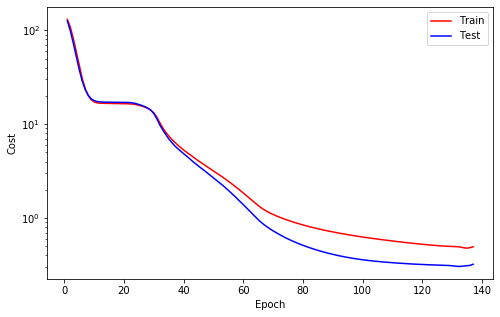

In [52]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [53]:
from utils import data4pred, pred4pred

In [54]:
train_forecast_set = TimeSeriesDataset(ts_train, 'Temp', 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, 'Temp', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

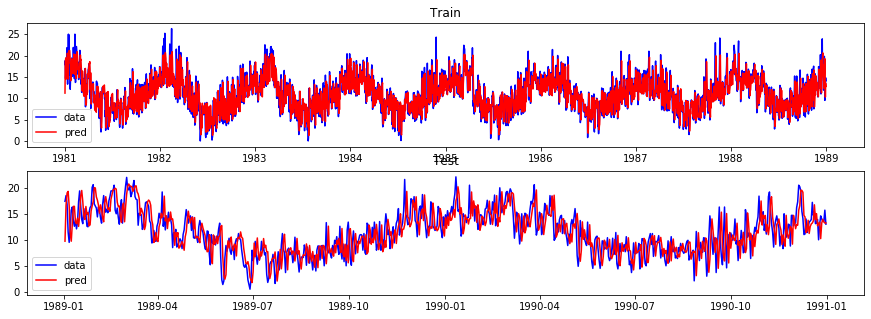

In [55]:
# Data For Pred
plt.figure(figsize=(15,5))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

Text(0.5, 1.0, 'Test')

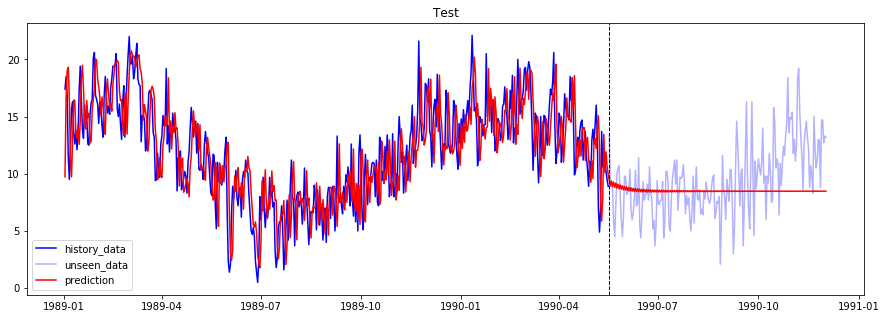

In [56]:
# Pred for pred
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

#### Umumnya pred for pred hanya dapat memprediksi 2 hari kedepan. untuk hari selanjutnya tidak dipakai karena terjadi domino effect yang terjadi apabila disuatu hari tersebut terjadi kesalahan maka hari selanjutnya akan menjadi salah terus 